# Bynary Classification

## Library & Dataset Import

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import os
import json
import joblib
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import random
import nlpaug.augmenter.word as naw
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    balanced_accuracy_score, precision_recall_curve, auc
)
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.base import BaseEstimator, TransformerMixin

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.w2v_feature_extraction import W2VTransformer
from utils.text_preprocessing import preprocess_text, TextPreprocessor

## Dataset balancing 

In [7]:
# Setting random parameter for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

df_train = pd.read_csv("../dataset/training_set.csv")  
df_train['text'] = df_train['text'].apply(preprocess_text)
df_train = df_train[['text', 'binary_label']]
df_train = df_train[
    df_train['text'].notna() & df_train['text'].str.strip().astype(bool)
]

df_minority = df_train[df_train["binary_label"] == "not_cyberbullying"]
df_majority = df_train[df_train["binary_label"] == "cyberbullying"]

print("Original distribution:")
print(df_train["binary_label"].value_counts())

aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)

df_majority = df_train[df_train["binary_label"] == df_train["binary_label"].value_counts().idxmax()]
df_minority = df_train[df_train["binary_label"] != df_train["binary_label"].value_counts().idxmax()]

target_size = int(1.5 * len(df_majority))

augmented_dfs = []

for label, df_subset in [("cyberbullying", df_train[df_train["binary_label"] == "cyberbullying"]),
                         ("not_cyberbullying", df_train[df_train["binary_label"] == "not_cyberbullying"])]:
    
    n_to_generate = target_size - len(df_subset)
    if n_to_generate <= 0:
        continue

    texts = df_subset["text"].tolist()
    augmented_texts = []
    i = 0
    while len(augmented_texts) < n_to_generate:
        text = texts[i % len(texts)]
        try:
            aug_text = aug.augment(text)
            augmented_texts.append(aug_text)
        except Exception:
            pass
        i += 1

    df_augmented = pd.DataFrame({
        "text": augmented_texts,
        "binary_label": label
    })
    augmented_dfs.append(df_augmented)

df_balanced = pd.concat([df_train] + augmented_dfs, ignore_index=True)
df_balanced = shuffle(df_balanced, random_state=SEED).reset_index(drop=True)

# --- --- --- ---
final_size = 20000
df_balanced = (
    df_balanced.groupby("binary_label")
    .apply(lambda x: x.sample(n=final_size, random_state=SEED))
    .reset_index(drop=True)
)
# --- --- --- ---


print("\nAfter balancing distribution:")
print(df_balanced["binary_label"].value_counts())

X_text = df_balanced["text"].fillna("").astype(str)
y_binary = df_balanced["binary_label"].map({
    "cyberbullying": 1,
    "not_cyberbullying": 0
})


model1 = Word2Vec.load("../model/word2vec_model1.model")



Original distribution:
binary_label
cyberbullying        31592
not_cyberbullying     6241
Name: count, dtype: int64

After balancing distribution:
binary_label
cyberbullying        20000
not_cyberbullying    20000
Name: count, dtype: int64


/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_1088/3450510986.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=final_size, random_state=SEED))


## GRID search

In [8]:
os.makedirs("../model", exist_ok=True)

combinations = [
    ("BoW", CountVectorizer(max_features=350)),
    ("TF-IDF", TfidfVectorizer(max_features=350)),
    ("W2V-1", W2VTransformer(model1))
]

param_grid = {
    "LogisticRegression": {
        "model__C": [0.01, 1, 10],
        "model__class_weight": ["balanced"]
    },
    "LinearSVM": {
        "model__C": [0.01, 0.1, 1, 10]
    },
    "RandomForest": {
        "model__n_estimators": [100, 200, 500, 1000],
        "model__max_depth": [None, 10, 20],
        "model__class_weight": ["balanced"],
        "model__random_state": [42]
    }
}

classifiers = [
    ("LogisticRegression", LogisticRegression(max_iter=1000), param_grid["LogisticRegression"]),
    ("RandomForest", RandomForestClassifier(), param_grid["RandomForest"]),
    ("LinearSVM", LinearSVC(max_iter=2000), param_grid["LinearSVM"])
]

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_results = []

for vec_name, vectorizer in combinations:
    for clf_name, clf, param_grid in classifiers:
        print(f"\GridSearchCV for {vec_name} + {clf_name}")
        
        pipeline = Pipeline([
            ("vectorizer", vectorizer),
            ("model", clf)
        ])
        
        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring=scoring,
            refit="f1",
            cv=cv,
            n_jobs=-1,
            verbose=1,
            return_train_score=False
        )
        
        grid.fit(X_text, y_binary)

        model_filename = f"../model/grid_search_binary_f1/{clf_name}_{vec_name}.pkl"
        joblib.dump(grid.best_estimator_, model_filename)

        best = {
            "Vectorizer": vec_name,
            "Classifier": clf_name,
            "Best Params": grid.best_params_,
            "Best Accuracy": grid.cv_results_["mean_test_accuracy"][grid.best_index_],
            "Best Precision": grid.cv_results_["mean_test_precision"][grid.best_index_],
            "Best Recall": grid.cv_results_["mean_test_recall"][grid.best_index_],
            "Best F1": grid.cv_results_["mean_test_f1"][grid.best_index_],
        }
        
        best_results.append(best)

results_df = pd.DataFrame(best_results)
results_df = results_df.sort_values(by="Best F1", ascending=False)


print(results_df)

results_df.to_csv("../model/grid_search_binary_f1/best_model_results.csv", index=False)


\GridSearchCV for BoW + LogisticRegression
Fitting 10 folds for each of 3 candidates, totalling 30 fits
\GridSearchCV for BoW + RandomForest
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


\GridSearchCV for BoW + LinearSVM
Fitting 10 folds for each of 4 candidates, totalling 40 fits
\GridSearchCV for TF-IDF + LogisticRegression
Fitting 10 folds for each of 3 candidates, totalling 30 fits
\GridSearchCV for TF-IDF + RandomForest
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


\GridSearchCV for TF-IDF + LinearSVM
Fitting 10 folds for each of 4 candidates, totalling 40 fits
\GridSearchCV for W2V-1 + LogisticRegression
Fitting 10 folds for each of 3 candidates, totalling 30 fits
\GridSearchCV for W2V-1 + RandomForest
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


\GridSearchCV for W2V-1 + LinearSVM
Fitting 10 folds for each of 4 candidates, totalling 40 fits
  Vectorizer          Classifier  \
1        BoW        RandomForest   
4     TF-IDF        RandomForest   
7      W2V-1        RandomForest   
0        BoW  LogisticRegression   
2        BoW           LinearSVM   
3     TF-IDF  LogisticRegression   
5     TF-IDF           LinearSVM   
6      W2V-1  LogisticRegression   
8      W2V-1           LinearSVM   

                                         Best Params  Best Accuracy  \
1  {'model__class_weight': 'balanced', 'model__ma...       0.882600   
4  {'model__class_weight': 'balanced', 'model__ma...       0.879675   
7  {'model__class_weight': 'balanced', 'model__ma...       0.846425   
0  {'model__C': 1, 'model__class_weight': 'balanc...       0.840075   
2                                  {'model__C': 0.1}       0.840850   
3  {'model__C': 10, 'model__class_weight': 'balan...       0.833600   
5                                   {'model__

## K-fold Cross Validation and Model Evaluation

In [9]:
y = y_binary

vectorizer_map = {
    "BoW": CountVectorizer(max_features=350),
    "TF-IDF": TfidfVectorizer(max_features=350),
    "W2V-1": W2VTransformer(model1)
}

classifier_map = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "LinearSVM": LinearSVC(max_iter=2000)
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),

    "precision_0": make_scorer(precision_score, pos_label=0, zero_division=0),
    "recall_0": make_scorer(recall_score, pos_label=0, zero_division=0),
    "f1_0": make_scorer(f1_score, pos_label=0, zero_division=0)
}


results = pd.read_csv("../model/grid_search_binary_f1/best_model_results.csv")
results["Best Params"] = results["Best Params"].apply(eval)

eval_results = []

for vec_name, vectorizer in vectorizer_map.items():
    for clf_name, clf in classifier_map.items():
        print(f"Validating {vec_name} + {clf_name} ...")

        row = results[(results["Vectorizer"] == vec_name) & (results["Classifier"] == clf_name)]
        if row.empty:
            print(f"No parameters found for {vec_name} + {clf_name}")
            continue
        best_params = row.iloc[0]["Best Params"]

        pipeline = Pipeline([
            ("vectorizer", vectorizer),
            ("model", clf)
        ])
        pipeline.set_params(**best_params)

        scores = cross_validate(
            pipeline,
            X_text,
            y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )

        result = {
            "model": clf_name,
            "vectorizer": vec_name
            
        }
        for key in scoring.keys():
            result[key] = np.mean(scores[f"test_{key}"])

        eval_results.append(result)

df_eval = pd.DataFrame(eval_results)
df_eval_sorted = df_eval.sort_values(by="f1", ascending=False)
df_eval_sorted.to_csv("../model/grid_search_binary_f1/binary_result_from_csv_params.csv", index=False)
display(df_eval_sorted)


Validating BoW + LogisticRegression ...
Validating BoW + RandomForest ...
Validating BoW + LinearSVM ...
Validating TF-IDF + LogisticRegression ...
Validating TF-IDF + RandomForest ...
Validating TF-IDF + LinearSVM ...
Validating W2V-1 + LogisticRegression ...
Validating W2V-1 + RandomForest ...
Validating W2V-1 + LinearSVM ...


,model,vectorizer,accuracy,precision,recall,f1,precision_0,recall_0,f1_0
1,RandomForest,BoW,0.882600,0.943363,0.81410,0.873949,0.836544,0.95110,0.890135
4,RandomForest,TF-IDF,0.879675,0.942437,0.80875,0.870462,0.832564,0.95060,0.887659
7,RandomForest,W2V-1,0.846425,0.894772,0.78520,0.836401,0.808653,0.90765,0.855289
0,LogisticRegression,BoW,0.840075,0.897304,0.76810,0.827658,0.797318,0.91205,0.850815
2,LinearSVM,BoW,0.840850,0.909955,0.75660,0.826194,0.791730,0.92510,0.853220
3,LogisticRegression,TF-IDF,0.833600,0.871115,0.78315,0.824760,0.803047,0.88405,0.841581
5,LinearSVM,TF-IDF,0.834100,0.879163,0.77475,0.823631,0.798672,0.89345,0.843387
6,LogisticRegression,W2V-1,0.764425,0.756285,0.78030,0.768064,0.773224,0.74855,0.760642
8,LinearSVM,W2V-1,0.768750,0.770624,0.76535,0.767926,0.767040,0.77215,0.769537



--- RandomForest + BoW ---
Accuracy:             0.7984
Balanced Accuracy:    0.7967
Precision:            0.9511
Recall (Sensitivity): 0.7992
Specificity:          0.7942
F1 Score:             0.8686
AUC-ROC:              0.8804
PR-AUC:               0.9755


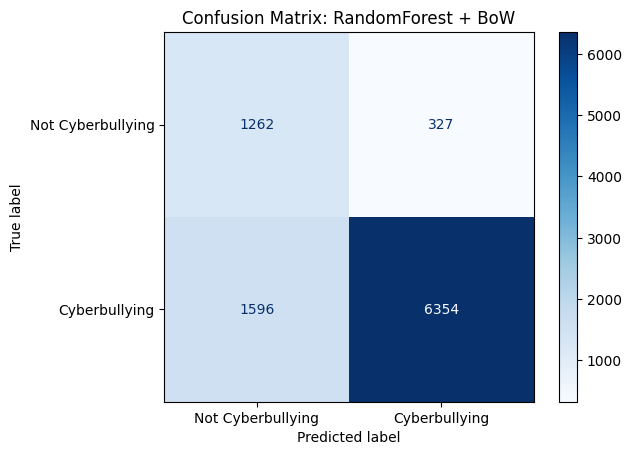


--- RandomForest + TF-IDF ---
Accuracy:             0.8012
Balanced Accuracy:    0.8047
Precision:            0.9546
Recall (Sensitivity): 0.7995
Specificity:          0.8099
F1 Score:             0.8702
AUC-ROC:              0.8865
PR-AUC:               0.9771


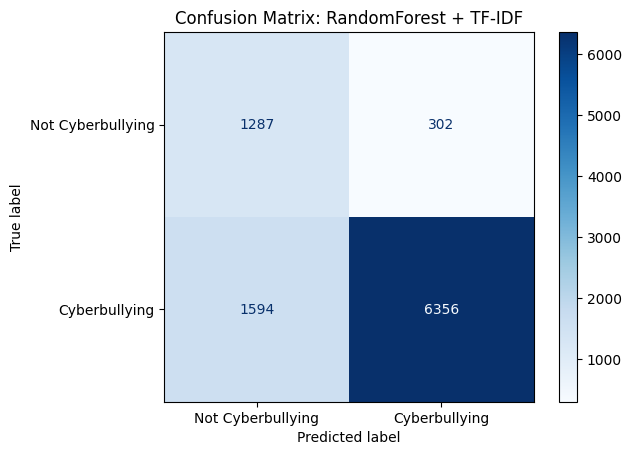


--- McNemar Test between Top 2 Models ---
McNemar's test statistic = 220.0, p-value = 0.2289
The difference is not statistically significant.


In [11]:
# test set loading
df_eval_sorted = pd.read_csv('../model/grid_search_binary_f1/binary_result_from_csv_params.csv')
df_test = pd.read_csv("../dataset/test_set.csv")
X_test_text = df_test["text"]
y_test = df_test["binary_label"].map({"cyberbullying": 1, "not_cyberbullying": 0}).values

top_models = df_eval_sorted.head(2)

# Evaluation Metrics
def print_metrics_and_confmat(y_true, y_pred, y_proba, title):
    print(f"\n--- {title} ---")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    spec = recall_score(y_true, y_pred, pos_label=0)
    auc_roc = roc_auc_score(y_true, y_proba)
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall_curve, precision_curve)

    print(f"Accuracy:             {acc:.4f}")
    print(f"Balanced Accuracy:    {bal_acc:.4f}")
    print(f"Precision:            {prec:.4f}")
    print(f"Recall (Sensitivity): {rec:.4f}")
    print(f"Specificity:          {spec:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"AUC-ROC:              {auc_roc:.4f}")
    print(f"PR-AUC:               {pr_auc:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Cyberbullying", "Cyberbullying"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {title}")
    plt.show()

predictions = []

predictions = []

for _, row in top_models.iterrows():
    model_name = row["model"]
    vectorizer_name = row["vectorizer"]
    
    file_name = f"../model/grid_search_binary_f1/{model_name}_{vectorizer_name}.pkl"
    clf = joblib.load(file_name)

    full_pipeline = Pipeline([
        ("preprocessing", TextPreprocessor()),
        *clf.steps  
    ])
    
    y_pred = full_pipeline.predict(X_test_text)
    y_proba = (
        full_pipeline.predict_proba(X_test_text)[:, 1]
        if hasattr(full_pipeline.named_steps["model"], "predict_proba")
        else y_pred
    )
    
    predictions.append(y_pred)
    
    print_metrics_and_confmat(y_test, y_pred, y_proba, f"{model_name} + {vectorizer_name}")


print("\n--- McNemar Test between Top 2 Models ---")
y_pred_1 = predictions[0]
y_pred_2 = predictions[1]

b = np.sum((y_pred_1 == y_test) & (y_pred_2 != y_test))
c = np.sum((y_pred_1 != y_test) & (y_pred_2 == y_test))

table = [[0, b], [c, 0]]
result = mcnemar(table, exact=True)

print(f"McNemar's test statistic = {result.statistic}, p-value = {result.pvalue:.4f}")
if result.pvalue < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")
